# Training Results Analysis & Visualization

**Purpose:** Analyze and visualize results from `src/run_training.py`

This notebook loads saved training artifacts and provides comprehensive analysis:
- Training curves (loss, accuracy, learning rate)
- Model performance metrics
- Class-wise performance analysis
- Confusion matrix
- Misclassification analysis

**Input Files:**
- `checkpoints/resnet50_full/training_history.csv`
- `checkpoints/resnet50_full/best_model.pth`
- `checkpoints/resnet50_full/training_metadata.json`

## 1. Setup

In [1]:
import sys
import json
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from sklearn.metrics import confusion_matrix, classification_report

# Add project root to path
project_root = Path.cwd().parent.parent
sys.path.insert(0, str(project_root))

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✓ Imports complete")

✓ Imports complete


## 2. Configuration

In [2]:
# Checkpoint directory to analyze
CHECKPOINT_DIR = '../../checkpoints/resnet50_full'

# File paths
HISTORY_PATH = Path(CHECKPOINT_DIR) / 'training_history.csv'
METADATA_PATH = Path(CHECKPOINT_DIR) / 'training_metadata.json'
MODEL_PATH = Path(CHECKPOINT_DIR) / 'best_model.pth'

# Output directory for figures
OUTPUT_DIR = Path(CHECKPOINT_DIR) / 'analysis'
OUTPUT_DIR.mkdir(exist_ok=True)

print(f"Checkpoint directory: {CHECKPOINT_DIR}")
print(f"Output directory: {OUTPUT_DIR}")

Checkpoint directory: ../../checkpoints/resnet50_full
Output directory: ../../checkpoints/resnet50_full/analysis


## 3. Load Training Artifacts

In [3]:
# Load training history
print("Loading training history...")
history_df = pd.read_csv(HISTORY_PATH)
print(f"  ✓ Loaded {len(history_df)} epochs")

# Load metadata
print("\nLoading training metadata...")
with open(METADATA_PATH, 'r') as f:
    metadata = json.load(f)
print(f"  ✓ Model: {metadata['model']}")
print(f"  ✓ Classes: {metadata['num_classes']}")
print(f"  ✓ Epochs trained: {metadata['training_config']['epochs']}")
print(f"  ✓ Batch size: {metadata['training_config']['batch_size']}")

# Display first few rows
print("\nTraining history preview:")
history_df.head()

Loading training history...
  ✓ Loaded 15 epochs

Loading training metadata...
  ✓ Model: resnet50
  ✓ Classes: 27
  ✓ Epochs trained: 15
  ✓ Batch size: 32

Training history preview:


,train_loss,train_acc,val_loss,val_acc,learning_rates
0,2.230533,37.261641,1.932431,43.931543,0.0001
1,2.038344,41.862528,1.877754,45.964830,0.0001
2,1.989270,42.926829,1.854383,46.396609,0.0001
3,1.957090,43.661308,1.842175,46.184644,0.0001
4,1.936749,44.086752,1.828855,47.911760,0.0001


## 4. Training Summary Statistics

In [4]:
# Find best epoch
best_epoch = history_df['val_loss'].idxmin()
best_val_loss = history_df.loc[best_epoch, 'val_loss']
best_val_acc = history_df.loc[best_epoch, 'val_acc']

# Final epoch results
final_train_loss = history_df['train_loss'].iloc[-1]
final_train_acc = history_df['train_acc'].iloc[-1]
final_val_loss = history_df['val_loss'].iloc[-1]
final_val_acc = history_df['val_acc'].iloc[-1]

print("=" * 70)
print("TRAINING SUMMARY")
print("=" * 70)

print(f"\nBest Results (Epoch {best_epoch + 1}):")
print(f"  Val Loss: {best_val_loss:.4f}")
print(f"  Val Accuracy: {best_val_acc:.2f}%")

print(f"\nFinal Results (Epoch {len(history_df)}):")
print(f"  Train Loss: {final_train_loss:.4f}")
print(f"  Train Accuracy: {final_train_acc:.2f}%")
print(f"  Val Loss: {final_val_loss:.4f}")
print(f"  Val Accuracy: {final_val_acc:.2f}%")

# Improvement metrics
train_acc_improvement = final_train_acc - history_df['train_acc'].iloc[0]
val_acc_improvement = final_val_acc - history_df['val_acc'].iloc[0]

print(f"\nImprovement from Epoch 1:")
print(f"  Train Accuracy: +{train_acc_improvement:.2f}%")
print(f"  Val Accuracy: +{val_acc_improvement:.2f}%")

# Overfitting check
train_val_gap = final_train_acc - final_val_acc
print(f"\nOverfitting Analysis:")
print(f"  Train-Val Gap: {train_val_gap:.2f}%")
if train_val_gap < 5:
    print("  Status: ✅ No significant overfitting")
elif train_val_gap < 10:
    print("  Status: ⚠️ Slight overfitting")
else:
    print("  Status: ❌ Significant overfitting - consider regularization")

TRAINING SUMMARY

Best Results (Epoch 14):
  Val Loss: 1.7441
  Val Accuracy: 49.65%

Final Results (Epoch 15):
  Train Loss: 1.8352
  Train Accuracy: 46.63%
  Val Loss: 1.7459
  Val Accuracy: 49.64%

Improvement from Epoch 1:
  Train Accuracy: +9.37%
  Val Accuracy: +5.71%

Overfitting Analysis:
  Train-Val Gap: -3.01%
  Status: ✅ No significant overfitting


## 5. Training Curves Visualization

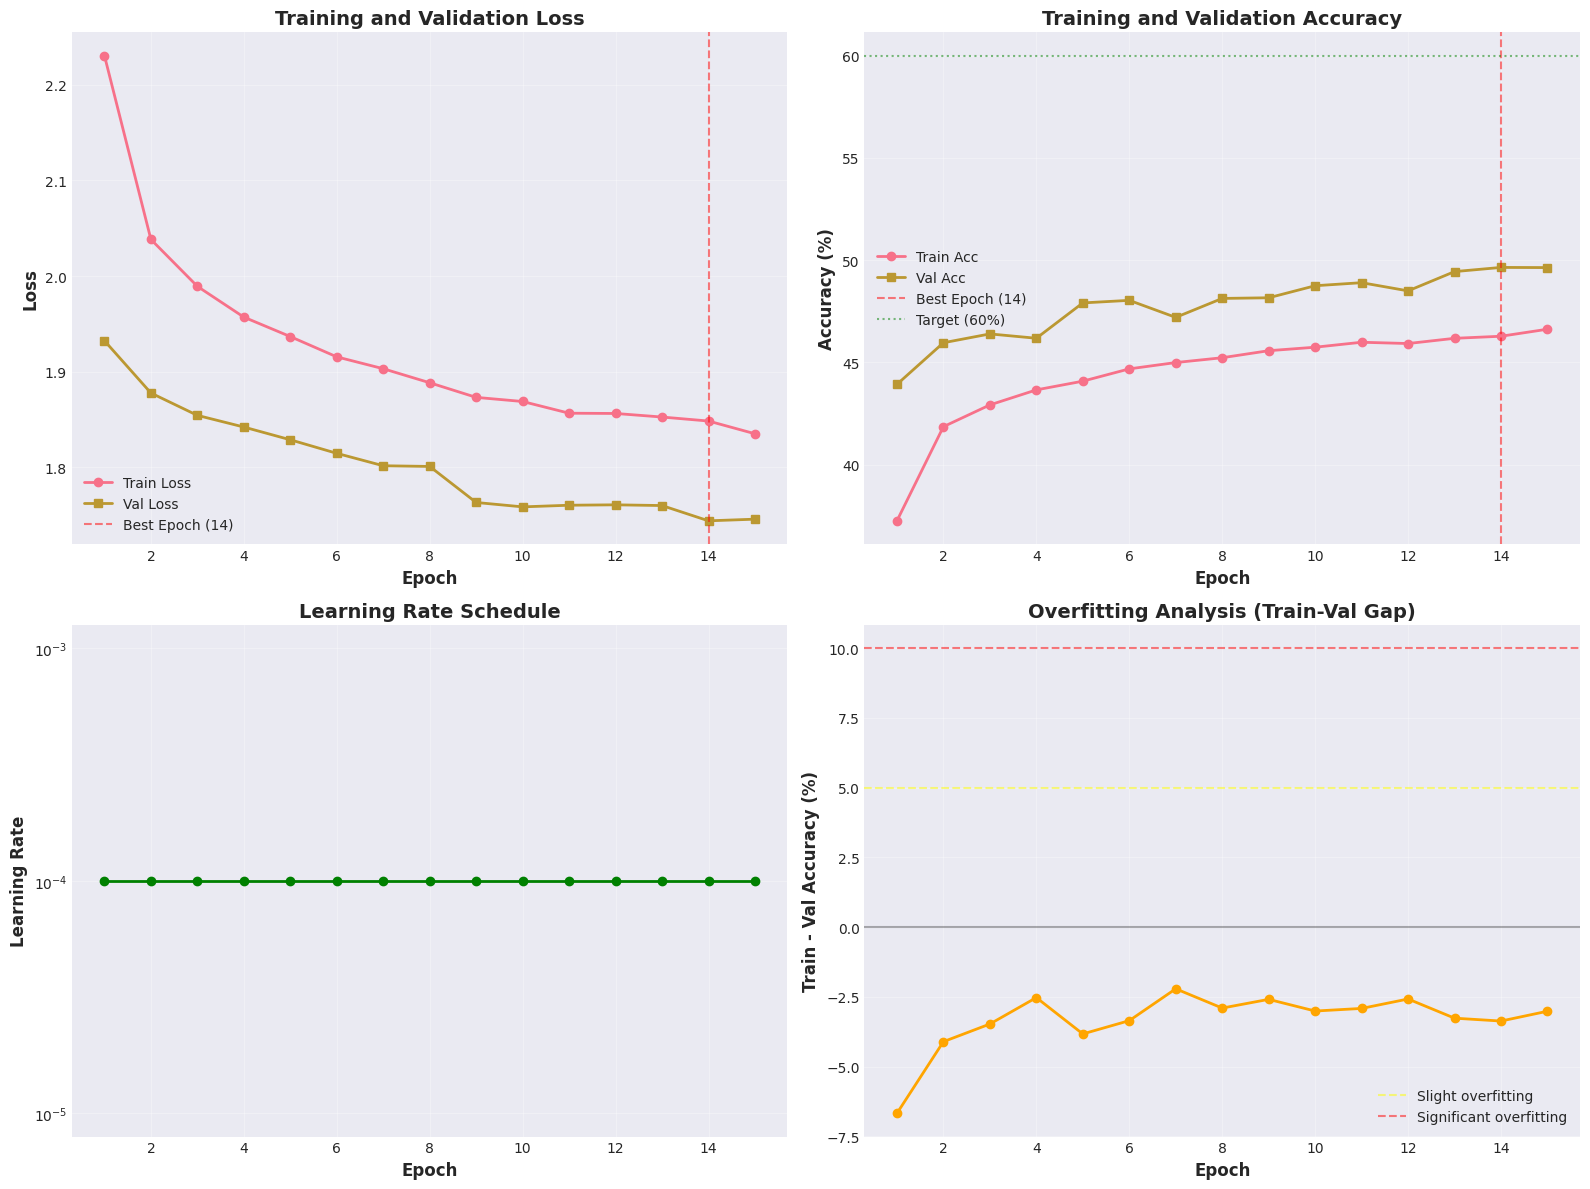

✓ Figure saved to ../../checkpoints/resnet50_full/analysis/training_curves.png


In [5]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Loss curves
ax = axes[0, 0]
ax.plot(history_df.index + 1, history_df['train_loss'], 
        label='Train Loss', marker='o', linewidth=2, markersize=6)
ax.plot(history_df.index + 1, history_df['val_loss'], 
        label='Val Loss', marker='s', linewidth=2, markersize=6)
ax.axvline(best_epoch + 1, color='red', linestyle='--', alpha=0.5, label=f'Best Epoch ({best_epoch + 1})')
ax.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax.set_ylabel('Loss', fontsize=12, fontweight='bold')
ax.set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# Plot 2: Accuracy curves
ax = axes[0, 1]
ax.plot(history_df.index + 1, history_df['train_acc'], 
        label='Train Acc', marker='o', linewidth=2, markersize=6)
ax.plot(history_df.index + 1, history_df['val_acc'], 
        label='Val Acc', marker='s', linewidth=2, markersize=6)
ax.axvline(best_epoch + 1, color='red', linestyle='--', alpha=0.5, label=f'Best Epoch ({best_epoch + 1})')
ax.axhline(60, color='green', linestyle=':', alpha=0.5, label='Target (60%)')
ax.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax.set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
ax.set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# Plot 3: Learning rate schedule
ax = axes[1, 0]
ax.plot(history_df.index + 1, history_df['learning_rates'], 
        marker='o', linewidth=2, markersize=6, color='green')
ax.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax.set_ylabel('Learning Rate', fontsize=12, fontweight='bold')
ax.set_title('Learning Rate Schedule', fontsize=14, fontweight='bold')
ax.set_yscale('log')
ax.grid(True, alpha=0.3)

# Plot 4: Train-Val Gap
ax = axes[1, 1]
train_val_gap = history_df['train_acc'] - history_df['val_acc']
ax.plot(history_df.index + 1, train_val_gap, 
        marker='o', linewidth=2, markersize=6, color='orange')
ax.axhline(0, color='black', linestyle='-', alpha=0.3)
ax.axhline(5, color='yellow', linestyle='--', alpha=0.5, label='Slight overfitting')
ax.axhline(10, color='red', linestyle='--', alpha=0.5, label='Significant overfitting')
ax.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax.set_ylabel('Train - Val Accuracy (%)', fontsize=12, fontweight='bold')
ax.set_title('Overfitting Analysis (Train-Val Gap)', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'training_curves.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"✓ Figure saved to {OUTPUT_DIR / 'training_curves.png'}")

## 6. Epoch-by-Epoch Analysis

In [6]:
# Show detailed epoch statistics
history_display = history_df.copy()
history_display.index = history_display.index + 1
history_display.index.name = 'Epoch'

# Add improvement columns
history_display['val_acc_delta'] = history_display['val_acc'].diff()
history_display['val_loss_delta'] = history_display['val_loss'].diff()

# Format for display
pd.options.display.float_format = '{:.4f}'.format

print("Epoch-by-Epoch Statistics:")
print("=" * 100)
history_display[['train_loss', 'train_acc', 'val_loss', 'val_acc', 'val_acc_delta', 'learning_rates']]

Epoch-by-Epoch Statistics:


,train_loss,train_acc,val_loss,val_acc,val_acc_delta,learning_rates
Epoch,,,,,,
1,2.2305,37.2616,1.9324,43.9315,NaN,0.0001
2,2.0383,41.8625,1.8778,45.9648,2.0333,0.0001
3,1.9893,42.9268,1.8544,46.3966,0.4318,0.0001
4,1.9571,43.6613,1.8422,46.1846,-0.2120,0.0001
5,1.9367,44.0868,1.8289,47.9118,1.7271,0.0001
6,1.9155,44.6882,1.8147,48.0374,0.1256,0.0001
7,1.9032,44.9972,1.8017,47.2052,-0.8322,0.0001
8,1.8885,45.2328,1.8010,48.1316,0.9264,0.0001
9,1.8732,45.5765,1.7633,48.1630,0.0314,0.0001


## 7. Model Evaluation (Optional - Requires Data)

In [7]:
# This section can be expanded to:
# 1. Load the best model
# 2. Run inference on validation set
# 3. Generate confusion matrix
# 4. Analyze per-class performance
# 5. Show misclassified examples

print("Model evaluation section (to be implemented)")
print(f"Model checkpoint available at: {MODEL_PATH}")
print("\nTo add evaluation:")
print("1. Load validation data")
print("2. Load best_model.pth")
print("3. Run inference")
print("4. Generate confusion matrix and classification report")

Model evaluation section (to be implemented)
Model checkpoint available at: ../../checkpoints/resnet50_full/best_model.pth

To add evaluation:
1. Load validation data
2. Load best_model.pth
3. Run inference
4. Generate confusion matrix and classification report


## 8. Recommendations

In [8]:
print("=" * 70)
print("RECOMMENDATIONS")
print("=" * 70)

# Based on results
if best_val_acc >= 60:
    print("\n✅ Excellent results! Val accuracy >= 60%")
    print("\nNext steps:")
    print("  1. Fine-tune with unfrozen backbone:")
    print("     python src/run_training.py --no_freeze_backbone --lr 1e-5 --epochs 10")
    print("  2. Try ensemble methods")
    print("  3. Deploy to production")
elif best_val_acc >= 50:
    print("\n⚠️ Moderate results. Consider:")
    print("\nRecommended actions:")
    print("  1. Train longer:")
    print("     python src/run_training.py --epochs 25")
    print("  2. Fine-tune backbone:")
    print("     python src/run_training.py --no_freeze_backbone --lr 1e-5")
    print("  3. Try different model:")
    print("     python src/run_training.py --model vit")
else:
    print("\n❌ Results below expectations. Investigate:")
    print("\nPossible issues:")
    print("  1. Data quality - check images and labels")
    print("  2. Model architecture - try different models")
    print("  3. Hyperparameters - adjust learning rate, batch size")
    print("  4. Training duration - train for more epochs")

# Overfitting analysis
if train_val_gap > 10:
    print("\n⚠️ Significant overfitting detected!")
    print("\nTry:")
    print("  - Increase dropout rate")
    print("  - Add more data augmentation")
    print("  - Reduce model complexity")
    print("  - Add L2 regularization")

print("\n" + "=" * 70)

RECOMMENDATIONS

❌ Results below expectations. Investigate:

Possible issues:
  1. Data quality - check images and labels
  2. Model architecture - try different models
  3. Hyperparameters - adjust learning rate, batch size
  4. Training duration - train for more epochs


ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

## 9. Export Summary Report

In [ ]:
# Create summary report
report = {
    'training_info': {
        'model': metadata['model'],
        'num_classes': metadata['num_classes'],
        'total_epochs': len(history_df),
        'batch_size': metadata['training_config']['batch_size'],
        'learning_rate': metadata['training_config']['learning_rate'],
    },
    'best_results': {
        'epoch': int(best_epoch + 1),
        'val_loss': float(best_val_loss),
        'val_accuracy': float(best_val_acc),
    },
    'final_results': {
        'train_loss': float(final_train_loss),
        'train_accuracy': float(final_train_acc),
        'val_loss': float(final_val_loss),
        'val_accuracy': float(final_val_acc),
    },
    'metrics': {
        'train_acc_improvement': float(train_acc_improvement),
        'val_acc_improvement': float(val_acc_improvement),
        'train_val_gap': float(train_val_gap),
    }
}

# Save report
report_path = OUTPUT_DIR / 'training_summary.json'
with open(report_path, 'w') as f:
    json.dump(report, f, indent=2)

print(f"✓ Summary report saved to {report_path}")
print("\nReport contents:")
print(json.dumps(report, indent=2))